## Loading Data, models

In [5]:
from proj.models import all_tokenizers
from proj.constants import DATA_DIR
from proj.data.data import split
import os
import pandas as pd

def split_col(df):
    train = df[df['phase'] == 'train']
    val = df[df['phase'] == 'dev']
    test = df[df['phase'] == 'test']
    return train, val, test
subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split_col(subset_df)

headline = lambda x: dfs[2].headline.iloc[x]
category = lambda x: dfs[2].category.iloc[x]

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap

CMAP = get_cmap("Blues")

def get_attentions(outputs, layer=5, attention_head=0, avg=True):
  '''
  get the particular output for a particular layer and attention head
  layer -> 0 to 11
  attention_head -> 0 to 11
  '''
  if avg:
    #avg over all attention heads in a layer
    returnVal =  outputs[layer].squeeze(0).mean(dim=0)
    returnVal[1:] = 0
    return returnVal

  #return values for a particular attention head inside a specific layer
  return outputs[layer].squeeze(0)[attention_head]

def plt_attentions(mat, labs, fig_size=(8,8), annot=False, cmap = CMAP, title=None):
  '''
  plot the NxN matrix passed as a heat map
  
  mat: square matrix to visualize
  labs: labels for xticks and yticks (the tokens in our case)
  '''

  fig, ax = plt.subplots(figsize=fig_size) 
  plt.subplots_adjust(left=0.125, bottom=0.01, right=0.9, top=0.9)
  ax = sns.heatmap(mat.detach().numpy(), annot=annot, yticklabels=labs,xticklabels=labs, cmap=cmap)
  ax.xaxis.set_ticks_position('top')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  if title:
    ax.set_title(title)

def attention_tokens(model, tokenizer, text):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    mask = inputs["attention_mask"]
    model.cpu()
    attention = model(input_ids, attention_mask=mask)[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    return attention, tokens

def show_head_view(model, tokenizer, text, layer=5):
    attention, tokens = attention_tokens(model, tokenizer, text)
    head_view(attention, tokens, layer=layer)

In [3]:
from bertviz import head_view, model_view
from proj.data.data import NewsDataset
from proj.models import all_models, all_tokenizers, DistilBertForSequenceClassification
import torch

tokenizer = all_tokenizers["distilBertPOS"]()
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=10, output_attentions=True)
model.resize_token_embeddings(len(tokenizer))
model.load_state_dict(torch.load("./proj/model_weights/60_20_20_split/distilBertPOS.pkl"))
transformerDS = NewsDataset(dfs[2], tokenizer=tokenizer, tag=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [10]:
show_head_view(model, tokenizer, headline(1000))

<IPython.core.display.Javascript object>

## Getting TopK Loss

In [6]:
from proj.data.data import *
from proj.main import *
from proj.models import all_tokenizers
import os
import pandas as pd

def split_col(df):
    train = df[df['phase'] == 'train']
    val = df[df['phase'] == 'dev']
    test = df[df['phase'] == 'test']
    return train, val, test
subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split_col(subset_df)
dls = []
bs = 256
model = "distilBert"
tokenizer = None
sampler = None

if model in all_tokenizers:
    tokenizer = all_tokenizers[model]()

for i, d in enumerate(dfs):
    ds = NewsDataset(d, tokenizer=tokenizer, stopwords=False)
    sampler = get_weighted_sampler(ds.labels()) if i == 0 else None
    dl = to_dataloader(ds, bs, sampler=sampler, drop_last=False)
    dls.append(dl)
model_name = "distilBert_topK"
hp = {**DEFAULT_HP, "model": model, "lr":2e-4, "epochs":5}
trainer = Trainer("_", model_name, dls, hp, bs)
trainer.load_weights("../ablation/distilbert_balanced.pkl")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [7]:
topK = trainer.topKLoss(2, 100)

100%|██████████| 42/42 [00:29<00:00,  1.42it/s]


## Visualization code

#### POS WordCloud data

In [41]:
from proj.data.data import *
from proj.main import *
from proj.models import all_tokenizers
import os
import pandas as pd
from collections import defaultdict
import torch 
from tqdm.auto import tqdm

subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split(subset_df)
bs = 256
modelName = "distilBertPOS"
tokenizer = None
sampler = None
tokenizer = all_tokenizers["distilBertPOS"]()
allResults = []
df = dfs[2]
model.cuda()
with torch.no_grad():
    for i, cat in enumerate(CATEGORY_SUBSET):
        allAttention = []
        allTokens = []
        catDf = df[df.category == cat]
        ds = NewsDataset(catDf, tokenizer=tokenizer, tag=True)
        dl = to_dataloader(ds, bs, sampler=None, drop_last=False)
        for xb, yb in tqdm(dl, total=len(dl)):
            input_ids = xb[0]
            attention = model(input_ids.cuda())[-1]
            attention = attention[5].squeeze(0).mean(dim=1) # now a 16, 16 shape
            # batch, 16, 16
            clsAttention = attention[:, 0, :].cpu()
            for ids in input_ids:
                input_id_list = ids.cpu().tolist() # Batch index 0
                tokens = tokenizer.convert_ids_to_tokens(input_id_list)
                allTokens.append(tokens)
            allAttention.append(clsAttention)
        allAttention = torch.cat(allAttention)
        allResults.append((allTokens, allAttention))

100%|██████████| 7/7 [00:27<00:00,  3.97s/it]


#### no POS wordcloud

In [5]:
from proj.models import DistilBertForSequenceClassification

subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split(subset_df)

dls = []
bs = 256
model = "distilBert"
tokenizer = None
sampler = None

if model in all_tokenizers:
    tokenizer = all_tokenizers[model]()

for i, d in enumerate(dfs):
    ds = NewsDataset(d, tokenizer=tokenizer)
    sampler = get_weighted_sampler(ds.labels()) if i == 0 else None
    dl = to_dataloader(ds, bs, sampler=sampler, drop_last=False)
    dls.append(dl)
model_name = "_"
hp = {**DEFAULT_HP, "model": model, "lr":2e-4, "epochs":5}
trainer = Trainer("60_20_20_split", model_name, dls, hp, bs)
trainer.load_weights("distilBert.pkl")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=10, output_attentions=True)

NameError: name 'pd' is not defined

In [22]:
allResults = []
df = dfs[2]
# model = trainer.model
with torch.no_grad():
    for i, cat in enumerate(CATEGORY_SUBSET):
        allAttention = []
        allTokens = []
        catDf = df[df.category == cat]
        ds = NewsDataset(catDf, tokenizer=tokenizer, tag=True)
        dl = to_dataloader(ds, bs, sampler=None, drop_last=False)
        for xb, yb in tqdm(dl, total=len(dl)):
            input_ids = xb[0]
            attention = model(input_ids.cuda())[-1]
            attention = attention[5].squeeze(0).mean(dim=1) # now a 16, 16 shape
            # batch, 16, 16
            clsAttention = attention[:, 0, :].cpu()
            for ids in input_ids:
                input_id_list = ids.cpu().tolist() # Batch index 0
                tokens = tokenizer.convert_ids_to_tokens(input_id_list)
                allTokens.append(tokens)
            allAttention.append(clsAttention)
        allAttention = torch.cat(allAttention)
        allResults.append((allTokens, allAttention))

100%|██████████| 7/7 [00:29<00:00,  4.23s/it]


In [42]:
finalData = []
for i, cat in enumerate(CATEGORY_SUBSET):
    attnDict = defaultdict(float)
    freqDict = defaultdict(int)
    data = allResults[i]
    tokens, attentions = data
    for j, currTokens in enumerate(tokens):
        currAttns = attentions[j]
        for k, tkn in enumerate(currTokens):
            freqDict[tkn] += 1
            attnDict[tkn] += currAttns[k]
    for tkn in attnDict:
        attnDict[tkn] = attnDict[tkn]/freqDict[tkn]
        attnDict[tkn] = attnDict[tkn].tolist() * 10_000
    finalData.append((freqDict, attnDict))

In [1]:
import pickle

# with open("./data/distilbertPOS_604040_attention_test_data.pkl", "wb") as outfile:
#     pickle.dump(finalData, outfile)

with open("./data/distilbert_604040_attention_test_data.pkl", "rb") as infile:
    finalData = pickle.load(infile)

In [46]:
import pickle

with open("./data/distilbertPOS_attention_test_data.pkl", "rb") as infile:
    posFinalData = pickle.load(infile)

In [83]:
catIdx = -1
sortedFirstCat = sorted(list(finalData[catIdx][1].items()), key=lambda d: d[1], reverse=True)

CRIME


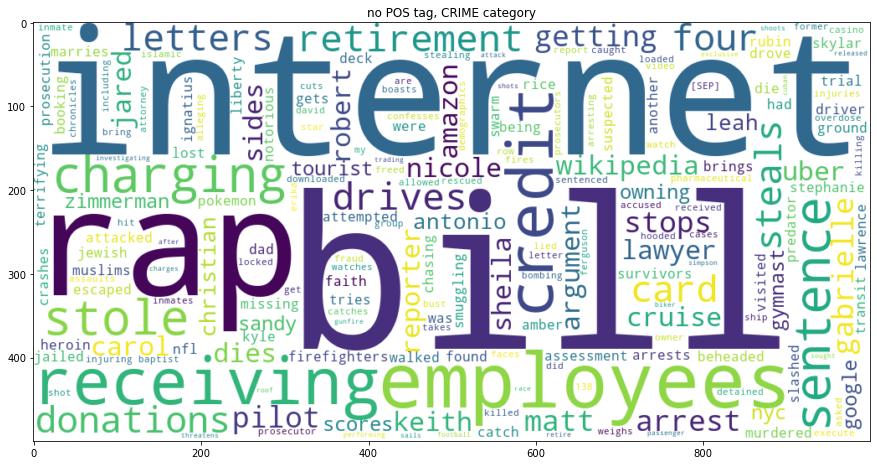

In [55]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
idx = 0
print(CATEGORY_SUBSET[idx])
freq = finalData[idx][1]
wc = WordCloud( background_color="white", width=1000, height=500)
wc.generate_from_frequencies(frequencies=freq)
plt.figure(figsize=(15,15))
plt.axes(title="no POS tag, CRIME category")
plt.imshow(wc, interpolation="bilinear", cmap=CMAP)

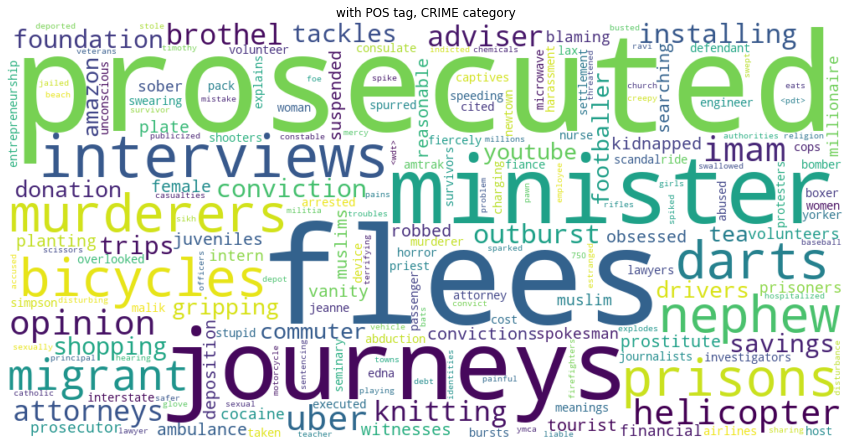

In [56]:
freq = posFinalData[idx][1]
wc = WordCloud( background_color="white", width=1000, height=500)
wc.generate_from_frequencies(frequencies=freq)
plt.figure(figsize=(15,15))
plt.axes(title="with POS tag, CRIME category")
plt.imshow(wc, interpolation="bilinear", cmap=CMAP)
plt.axis("off")
plt.show()

In [74]:
from proj.models import all_models

In [80]:
from proj.constants import DISTILBERT_POS_TOKENIZER
from proj.models import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(DISTILBERT_POS_TOKENIZER, is_split_into_words=True)
tokenizer.encode_plus("apologizing")

{'input_ids': [101, 9706, 12898, 28660, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [95]:
len(transformerDS.tokenize(headline(idx)))

22

In [34]:
from bertviz import head_view, model_view
from proj.constants import CATEGORY_SUBSET
from proj.data.data import NewsDataset
from proj.models import all_models, all_tokenizers, DistilBertForSequenceClassification
import torch

tokenizer = all_tokenizers["distilBert"]()
tfmer = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=10, output_attentions=True)
# tfmer.resize_token_embeddings(len(tokenizer))
tfmer.load_state_dict(torch.load("./proj/model_weights/ablation/distilbert_balanced.pkl"))
transformerDS = NewsDataset(dfs[2], tokenizer=tokenizer)
dfs = split_col(subset_df)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [51]:
from proj.data.data import *
from proj.main import *
from proj.models import all_tokenizers
import os
import pandas as pd

def split_col(df):
    train = df[df['phase'] == 'train']
    val = df[df['phase'] == 'dev']
    test = df[df['phase'] == 'test']
    return train, val, test
subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split_col(subset_df)
dls = []
bs = 128
model = "lstmAttention"
sampler = None

if model in all_tokenizers:
    tokenizer = all_tokenizers[model]()

for i, d in enumerate(dfs):
    ds = NewsDataset(d, tokenizer=None)
    # sampler = get_weighted_sampler(ds.labels()) if i == 0 else None
    dl = to_dataloader(ds, bs, sampler=sampler, drop_last=True)
    dls.append(dl)
model_name = "lstmAttention_embed_train"
hp = {**DEFAULT_HP, "model": model, "lr":2e-4, "epochs":10}
trainer = Trainer("padded", model_name, dls, hp, bs)
trainer.load_weights(f"{model_name}.pkl")

C:\Users\ngbra\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [52]:
model = trainer.model
model.attentionOutput = True

In [53]:
# xb, yb = next(iter(dls[2]))
phase = 2
ds = dls[phase].dataset
dl = dls[phase]
xb, yb = next(iter(dl))
xb = xb[0].cuda(), xb[1]
out, attn = model(xb)

In [5]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

packed = pack_padded_sequence(
            xb[0], xb[1], batch_first=True, enforce_sorted=False)
# Forward pass through LSTM
# outputs, hidden = self.lstm(packed, self.hidden)
padded = pad_packed_sequence(packed, batch_first=True)[0]

                predicted: ENTERTAINMENT ,actual: ENTERTAINMENT


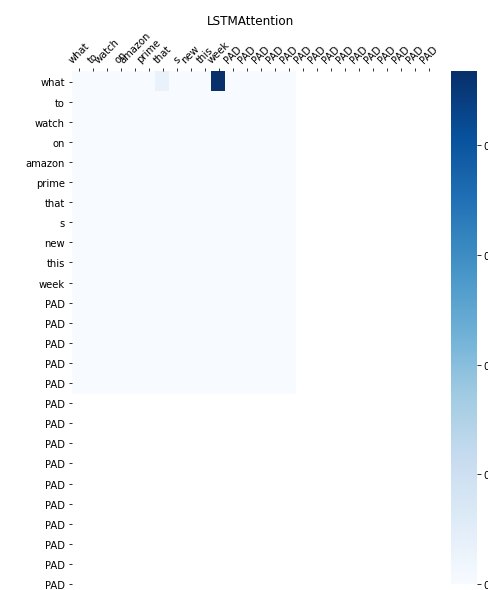

In [57]:
# 73, 71
idx = 71
tokenIds = ds[idx][0][0]
tokens = []
for tkid in tokenIds:
    if tkid == 400001:
        tokens.append("PAD")
        continue
    if tkid >= 400000:
        tokens.append("UNK")
        continue
    tokens.append(ds.glove.itos[tkid])
attnMap = attn[idx][0].cpu()
attnMatrix = torch.cat([attnMap.unsqueeze(0), torch.zeros(15,16)])
print("                predicted:", CATEGORY_SUBSET[torch.argmax(out[idx]).cpu()],",actual:", CATEGORY_SUBSET[ds[idx][1]])
plt_attentions(attnMatrix, tokens, title="LSTMAttention")

In [36]:
tfmer = trainer.model.cpu()

In [33]:
topKIndices = topK.indices.tolist()

In [40]:
from proj.data.data import NewsDataset
# Use idx 0 for good comparison
# idx = 7011
transformerDS = NewsDataset(dfs[2], tokenizer=tokenizer)
toTry = []
# for idx in toLook[lstIdx:lstIdx+1]:
lstIdx = 2
for idx in topKIndices[lstIdx:lstIdx+1]:
# for idx in range(6000,6100):
    (inputIds, attention_mask), label = transformerDS[idx]
    outputs = tfmer(
        inputIds.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )
    pred = CATEGORY_SUBSET[torch.argmax(outputs[0].cpu())]
    actual = category(idx)
    if pred!=actual:
        toTry.append(idx)
    print("         predicted:", CATEGORY_SUBSET[torch.argmax(outputs[0].cpu())],",actual:", category(idx))
    text = " ".join(transformerDS.tokenize(headline(idx)))
    attention, tokens = attention_tokens(tfmer, tokenizer, transformerDS.tokenize(headline(idx)))
    plt_attentions(get_attentions(attention), tokens, title="Transformer")

         predicted: ENTERTAINMENT ,actual: STYLE


IndexError: index 5 is out of bounds for dimension 0 with size 1

         predicted: ENTERTAINMENT ,actual: ENTERTAINMENT


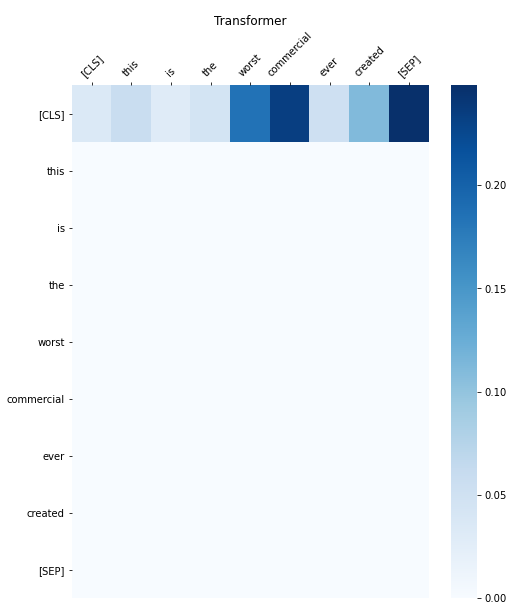

In [37]:
from proj.data.data import NewsDataset
# Use idx 0 for good comparison
# idx = 7011
transformerDS = NewsDataset(dfs[2], tokenizer=tokenizer)
toTry = []
# for idx in toLook[lstIdx:lstIdx+1]:
for idx in [6155]:
# for idx in range(6000,6100):
    (inputIds, attention_mask), label = transformerDS[idx]
    outputs = tfmer(
        inputIds.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )
    pred = CATEGORY_SUBSET[torch.argmax(outputs[0].cpu())]
    actual = category(idx)
    if pred!=actual:
        toTry.append(idx)
    print("         predicted:", CATEGORY_SUBSET[torch.argmax(outputs[0].cpu())],",actual:", category(idx))
    text = " ".join(transformerDS.tokenize(headline(idx)))
    attention, tokens = attention_tokens(tfmer, tokenizer, transformerDS.tokenize(headline(idx)))
    plt_attentions(get_attentions(attention), tokens, title="Transformer")

In [7]:
from bertviz import head_view, model_view
from proj.data.data import NewsDataset
from proj.models import all_models, all_tokenizers, DistilBertForSequenceClassification
import torch

dfs = split_col(subset_df)

posTokenizer = all_tokenizers["distilBertPOS"]()
posTfmer = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=10, output_attentions=True)
posTfmer.resize_token_embeddings(len(posTokenizer))
# posTfmer.load_state_dict(torch.load("./proj/model_weights/POS/distilBert_pos.pkl"))
posTfmer.load_state_dict(torch.load("./proj/model_weights/60_20_20_split/distilBert_pos.pkl"))
posDS = NewsDataset(dfs[2], tokenizer=posTokenizer, tag=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

6155
          This Is The Worst Commercial Ever Created
          predicted: ENTERTAINMENT ,actual: ENTERTAINMENT


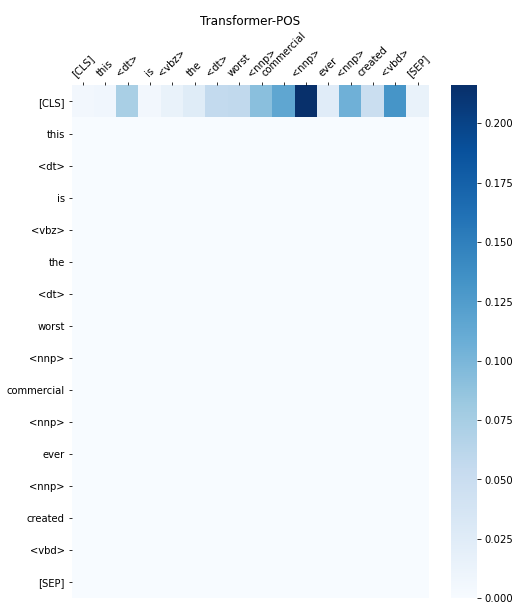

In [8]:
from proj.data.data import NewsDataset
from proj.constants import CATEGORY_SUBSET
# Use idx 0 for good comparison
# 7007 shows that it provides some meaning to UNK
# idx = 1
# idx 6150 for POS
# idx 
lstIdx = 6
toLook = []
for idx in [6155]:
# for idx in toLook[lstIdx:lstIdx+1]:
# for idx in toTry:
    print(idx)
    (inputIds, attention_mask), label = posDS[idx]
    outputs = posTfmer(
        inputIds.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )
    pred = CATEGORY_SUBSET[torch.argmax(outputs[0].cpu())]
    actual = category(idx)
    # if pred==actual:
    toLook.append(idx)
    text = " ".join(posDS.tokenize(headline(idx)))
    attention, tokens = attention_tokens(posTfmer, posTokenizer, posDS.tokenize(headline(idx)))
    print("         ",headline(idx))
    print("          predicted:", CATEGORY_SUBSET[torch.argmax(outputs[0].cpu())],",actual:", category(idx))
    plt_attentions(get_attentions(attention), tokens, title="Transformer-POS")

In [17]:
attention[0]

torch.Size([1, 12, 12, 12])